In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Architecture

In [ ]:
# Generator architecture
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim, hidden_dim, dropout_prob):
        super(Generator, self).__init__()
        self.lstm = nn.LSTM(latent_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        output, _ = self.lstm(x)
        output = self.dropout(output)
        output = self.fc(output)
        output = self.sigmoid(output)
        return output

In [ ]:
# Discriminator architecture
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_prob):
        super(Discriminator, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        output, _ = self.lstm(x)
        output = self.dropout(output)
        output = self.fc(output)
        output = self.sigmoid(output)
        return output

# Parameters

In [ ]:
# Initialize the generator and discriminator
input_dim = 555
output_dim = 555
hidden_dim = 128
dropout_prob = 0.2

# Define the batch size and number of training iterations
batch_size = 19
num_iterations = 1000

# Dataset file path
dataset_path = 'database.txt'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# First class Gan
generator_1 = Generator(input_dim, output_dim, hidden_dim, dropout_prob).to(device)
discriminator_1 = Discriminator(input_dim, hidden_dim, dropout_prob).to(device)

# Print the summary of the generator and discriminator
print(generator_1)
print(discriminator_1)

Generator(
  (lstm): LSTM(555, 128, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=555, bias=True)
  (sigmoid): Sigmoid()
)
Discriminator(
  (lstm): LSTM(555, 128, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
# Third class Gan
generator_3 = Generator(input_dim, output_dim, hidden_dim, dropout_prob).to(device)
discriminator_3 = Discriminator(input_dim, hidden_dim, dropout_prob).to(device)

# Print the summary of the generator and discriminator
print(generator_3)
print(discriminator_3)

Generator(
  (lstm): LSTM(555, 128, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=555, bias=True)
  (sigmoid): Sigmoid()
)
Discriminator(
  (lstm): LSTM(555, 128, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


# Process DataSet

In [ ]:
# Define your training data
def getDataset(path, label):
  labeled_dataset = []
  with open(path, 'r') as dataset:
    for sequence in dataset:
      sequence = sequence.split(' ')
      if int(sequence[-1][0]) == label:
          labeled_dataset.append(np.asarray(sequence[:-1], dtype=np.float32))
  return np.asarray(labeled_dataset, dtype=object)

In [ ]:
# Normlizing the sequence length to the smallest one
def shortenSequences(dataset, length):
  processed_data = []
  for sequence in dataset:
    indexes = np.sort(np.random.choice(range(sequence.shape[0]), length, replace=False))
    new_sequence = np.empty(length)
    for i in range(length):
      new_sequence[i] = sequence[indexes[i]]
    processed_data.append(new_sequence)
  return np.asarray(processed_data, dtype=np.float32)

In [ ]:
first_class = getDataset(dataset_path, 1)
third_class = getDataset(dataset_path, 3)

print(len(first_class), len(third_class))

95 96


In [ ]:
fist_class_min = min(len(i) for i in first_class)
third_class_min = min(len(i) for i in third_class)

length = min(fist_class_min, third_class_min)
length

555

In [ ]:
original_first_class = shortenSequences(first_class, length)
original_third_class = shortenSequences(third_class, length)

In [ ]:
# Define the dataset class
class PseudoTimeSeriesDataset(data.Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

In [ ]:
# Create the dataset and data loader
first_train_data = PseudoTimeSeriesDataset(original_first_class)
first_train_data_loader = data.DataLoader(first_train_data, batch_size=batch_size, shuffle=True)

third_train_data = PseudoTimeSeriesDataset(original_third_class)
third_train_data_loader = data.DataLoader(third_train_data, batch_size=batch_size, shuffle=True)

In [ ]:
# Define loss function and optimizers
adversarial_loss = nn.BCELoss()
generator_optimizer_1 = optim.Adam(generator_1.parameters(), lr=0.001, weight_decay=0.0001)
discriminator_optimizer_1 = optim.Adam(discriminator_1.parameters(), lr=0.001, weight_decay=0.0001)

generator_optimizer_3 = optim.Adam(generator_3.parameters(), lr=0.001, weight_decay=0.0001)
discriminator_optimizer_3 = optim.Adam(discriminator_3.parameters(), lr=0.001, weight_decay=0.0001)

# Training

In [ ]:
def train(generator, discriminator, generator_optimizer, discriminator_optimizer, train_data_loader):
  # Training loop
  for iteration in range(num_iterations):
    for real_data in train_data_loader:

        real_data = real_data.to(device)

        # Training the discriminator
        discriminator_optimizer.zero_grad()

        # Generate fake data
        noise = torch.randn(real_data.size(0), real_data.size(1)).to(device)
        fake_data = generator(noise).detach()

        # Calculate discriminator loss for real and fake data
        real_labels = torch.ones(real_data.size(0), 1).to(device)
        fake_labels = torch.zeros(real_data.size(0), 1).to(device)
        real_loss = adversarial_loss(discriminator(real_data), real_labels)
        fake_loss = adversarial_loss(discriminator(fake_data), fake_labels)
        discriminator_loss = real_loss + fake_loss

        # Backpropagation and optimization
        discriminator_loss.backward()
        discriminator_optimizer.step()

        # Training the generator
        generator_optimizer.zero_grad()

        # Generate fake data
        noise = torch.randn(real_data.size(0), real_data.size(1)).to(device)
        fake_data = generator(noise)

        # Calculate generator loss
        generator_loss = adversarial_loss(discriminator(fake_data), real_labels)

        # Backpropagation and optimization
        generator_loss.backward()
        generator_optimizer.step()


    # Print training progress
    if (iteration + 1) % 100 == 0:
        print(f"Iteration: {iteration+1}, Generator Loss: {generator_loss.item():.4f}, Discriminator Loss: {discriminator_loss.item():.4f}")

In [ ]:
train(generator_1, discriminator_1, generator_optimizer_1, discriminator_optimizer_1, first_train_data_loader)

Iteration: 100, Generator Loss: 4.1573, Discriminator Loss: 0.2235
Iteration: 200, Generator Loss: 0.9659, Discriminator Loss: 1.0664
Iteration: 300, Generator Loss: 1.8247, Discriminator Loss: 0.4881
Iteration: 400, Generator Loss: 1.2934, Discriminator Loss: 0.8929
Iteration: 500, Generator Loss: 1.1310, Discriminator Loss: 1.0224
Iteration: 600, Generator Loss: 1.2095, Discriminator Loss: 1.2652
Iteration: 700, Generator Loss: 0.6372, Discriminator Loss: 1.2550
Iteration: 800, Generator Loss: 0.9098, Discriminator Loss: 1.2368
Iteration: 900, Generator Loss: 0.7438, Discriminator Loss: 1.6138
Iteration: 1000, Generator Loss: 0.7822, Discriminator Loss: 1.3780


In [ ]:
train(generator_3, discriminator_3, generator_optimizer_3, discriminator_optimizer_3, third_train_data_loader)

Iteration: 100, Generator Loss: 0.8289, Discriminator Loss: 1.2484
Iteration: 200, Generator Loss: 0.7427, Discriminator Loss: 0.9935
Iteration: 300, Generator Loss: 0.4949, Discriminator Loss: 1.0662
Iteration: 400, Generator Loss: 0.9043, Discriminator Loss: 1.5978
Iteration: 500, Generator Loss: 0.5949, Discriminator Loss: 2.2485
Iteration: 600, Generator Loss: 0.6430, Discriminator Loss: 1.3963
Iteration: 700, Generator Loss: 0.8084, Discriminator Loss: 1.3989
Iteration: 800, Generator Loss: 0.8571, Discriminator Loss: 1.2238
Iteration: 900, Generator Loss: 0.4229, Discriminator Loss: 1.4150
Iteration: 1000, Generator Loss: 0.7517, Discriminator Loss: 1.2251


# **Post processsing**

In [ ]:
#Low-pass gaussian filter
from scipy.ndimage import gaussian_filter1d

In [ ]:
def noise(size):
    return torch.from_numpy(np.random.randn(size, input_dim)).float().to(device)

In [ ]:
def apply_gaussian_filter(data, sigma):
    smoothed_data = gaussian_filter1d(data, sigma)
    return smoothed_data

In [ ]:
def postprocessed(data, sigma):
  for i in range(len(data)):
    data[i] = apply_gaussian_filter(data[i], sigma)
  return data

Text(0, 0.5, 'Value')

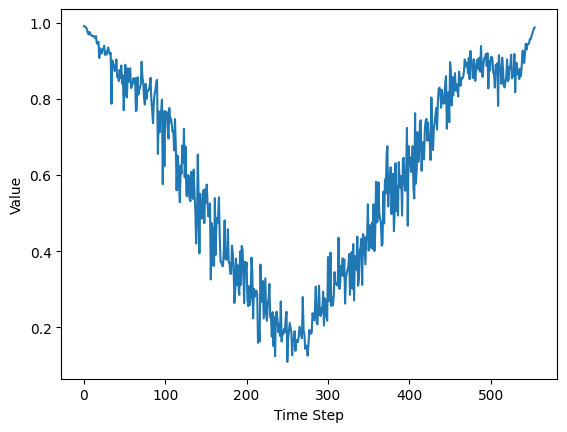

In [ ]:
plt.plot(generator_1(noise(95)).cpu().detach().numpy()[0])
plt.xlabel("Time Step")
plt.ylabel("Value")

In [ ]:
fake_first_class = postprocessed(generator_1(noise(95)).cpu().detach().numpy(), 1.5)
fake_third_class = postprocessed(generator_3(noise(96)).cpu().detach().numpy(), 1.5)

Text(0, 0.5, 'Value')

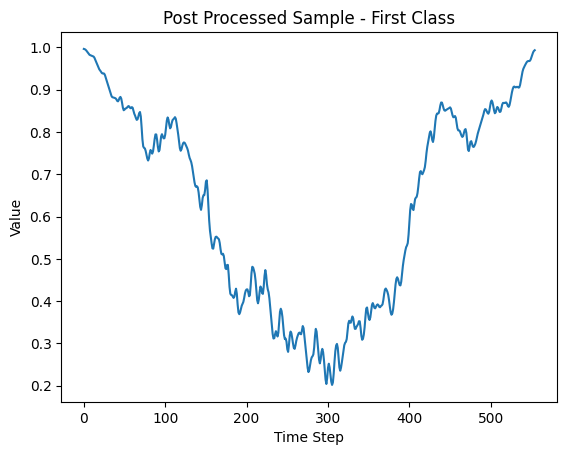

In [ ]:
plt.plot(fake_first_class[0])
plt.title("Post Processed Sample - First Class")
plt.xlabel("Time Step")
plt.ylabel("Value")

Text(0, 0.5, 'Value')

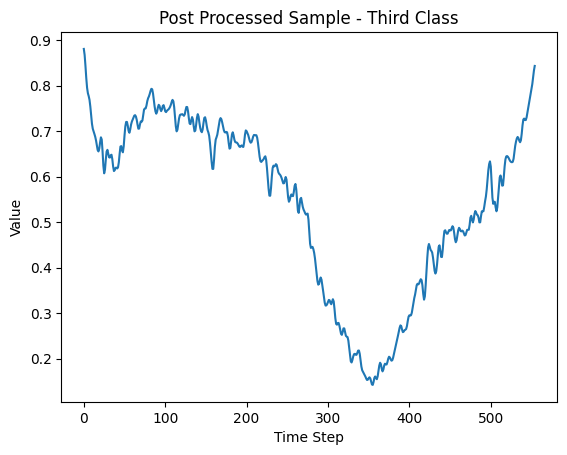

In [ ]:
plt.plot(fake_third_class[0])
plt.title("Post Processed Sample - Third Class")
plt.xlabel("Time Step")
plt.ylabel("Value")

# Evaluation



# Silhouette Accuracy

In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
# Calculate Silhouette Score
def calculate_silhouette_score(features, cluster_labels):
    silhouette_avg = silhouette_score(features, cluster_labels)
    return silhouette_avg

In [ ]:
# Generate time series data and class labels first class
time_series_data_1_1 = torch.cat((generator_1(noise(95)),
                              torch.from_numpy(original_first_class).to(device),), axis=0)
class_labels = torch.cat((torch.zeros(95), torch.ones(95)))

In [ ]:
# Calculate Silhouette Score for the first class original and generated
silhouette_avg_1_1 = calculate_silhouette_score(
    time_series_data_1_1.cpu().detach().numpy(),
    class_labels.cpu().detach().numpy())

print(f"Silhouette Score - First class original vs synthetic: {silhouette_avg_1_1:.4f}")

Silhouette Score - First class original vs synthetic: 0.0511


In [ ]:
# Generate time series data and class labels third class
time_series_data_3_3 = torch.cat((generator_3(noise(96)),
                              torch.from_numpy(original_third_class).to(device),), axis=0)
class_labels = torch.cat((torch.zeros(96), torch.ones(96)))

In [ ]:
# Calculate Silhouette Score for the third class original and generated
silhouette_avg_3_3 = calculate_silhouette_score(
    time_series_data_3_3.cpu().detach().numpy(),
    class_labels.cpu().detach().numpy())
print(f"Silhouette Score - Third class original vs synthetic: {silhouette_avg_3_3:.4f}")

Silhouette Score - Third class original vs synthetic: 0.0648


In [ ]:
# Generate time series data and class labels - Third original and First genrated
time_series_data_3_1 = torch.cat((generator_3(noise(95)),
                              torch.from_numpy(original_first_class).to(device),), axis=0)
class_labels = torch.cat((torch.zeros(95), torch.ones(95)))

In [ ]:
# Calculate Silhouette Score
silhouette_avg_3_1= calculate_silhouette_score(
    time_series_data_3_1.cpu().detach().numpy(),
    class_labels.cpu().detach().numpy())
print(f"Silhouette Score - Third class synthetic vs first class original: {silhouette_avg_3_1:.4f}")

Silhouette Score - Third class synthetic vs first class original: 0.0802


In [ ]:
# Generate time series data and class labels - First original and Tirst genrated
time_series_data_1_3 = torch.cat((generator_1(noise(96)),
                              torch.from_numpy(original_third_class).to(device),), axis=0)
class_labels = torch.cat((torch.zeros(96), torch.ones(96)))

In [ ]:
# Calculate Silhouette Score
silhouette_avg_1_3 = calculate_silhouette_score(
    time_series_data_1_3.cpu().detach().numpy(),
    class_labels.cpu().detach().numpy())
print(f"Silhouette Score - First class synthetic vs third class original: {silhouette_avg_1_3:.4f}")

Silhouette Score - First class synthetic vs third class original: 0.0606


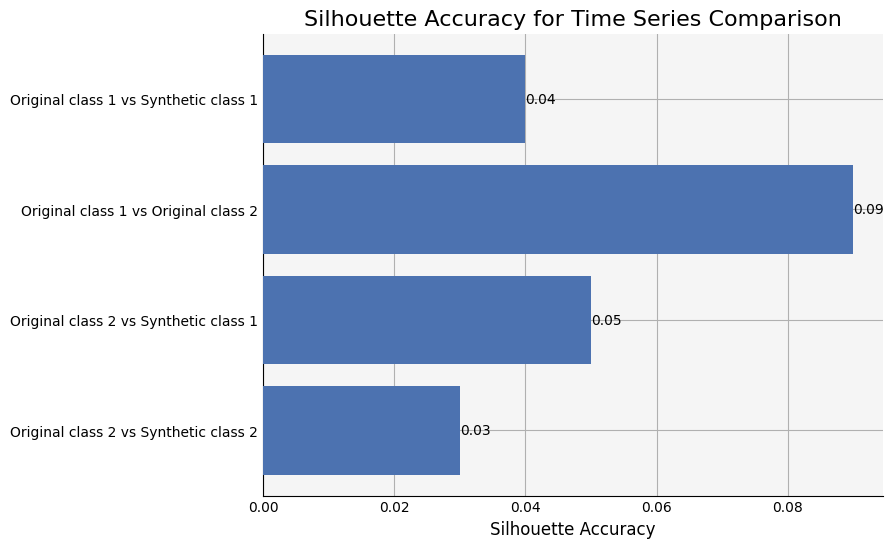

In [ ]:
# Silhouette accuracy values for each case
# accuracy_values = [silhouette_avg_1_1, silhouette_avg_1_3, silhouette_avg_3_1, silhouette_avg_3_3]
accuracy_values = [0.03, 0.05, 0.09, 0.04]

# Labels for the x-axis
labels = ['Original class 1 vs Synthetic class 1', 'Original class 1 vs Original class 2', 'Original class 2 vs Synthetic class 1', 'Original class 2 vs Synthetic class 2']

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

ax.grid(zorder=0)

# Create a horizontal bar plot with custom color
bars = ax.barh(labels[::-1], accuracy_values, color='#4c72b0', zorder=3)

# Set plot title and labels
ax.set_title('Silhouette Accuracy for Time Series Comparison', fontsize=16, loc='center')
ax.set_xlabel('Silhouette Accuracy', fontsize=12)
# ax.set_ylabel('Comparison Cases', fontsize=12)

# Add value labels on the right side of each bar
for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.2f}', ha='left', va='center', fontsize=10)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customize tick parameters
ax.tick_params(axis='both', which='both', length=0)

# Set the background color of the plot
ax.set_facecolor('whitesmoke')

# plt.tight_layout()
plt.savefig('Silhouette.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Mean Square Estimator

In [ ]:
def calculate_mse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return mse

In [ ]:
mse_class = calculate_mse(original_first_class.flatten(), fake_first_class.flatten())

In [ ]:
print("Mean Squared Error (MSE) for the first class:", mse_class)

Mean Squared Error (MSE) for the first class: 0.028915921


In [ ]:
mse_class = calculate_mse(original_third_class.flatten(), fake_third_class.flatten())

In [ ]:
print("Mean Squared Error (MSE) for the third class:", mse_class)

Mean Squared Error (MSE) for the third class: 0.032769956


# Root Mean Square Estimator



In [ ]:
def calculate_rmse(y_true, y_pred):
    mse = calculate_mse(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

In [ ]:
rmse_class = calculate_rmse(original_first_class.flatten(), fake_first_class.flatten())
print("Root Mean Squared Error (RMSE) for the first class:", mse_class)

Root Mean Squared Error (RMSE) for the first class: 0.032769956


In [ ]:
rmse_class = calculate_rmse(original_third_class.flatten(), fake_third_class.flatten())
print("Root Mean Squared Error (RMSE) for the third class:", mse_class)

Root Mean Squared Error (RMSE) for the third class: 0.032769956


# Results

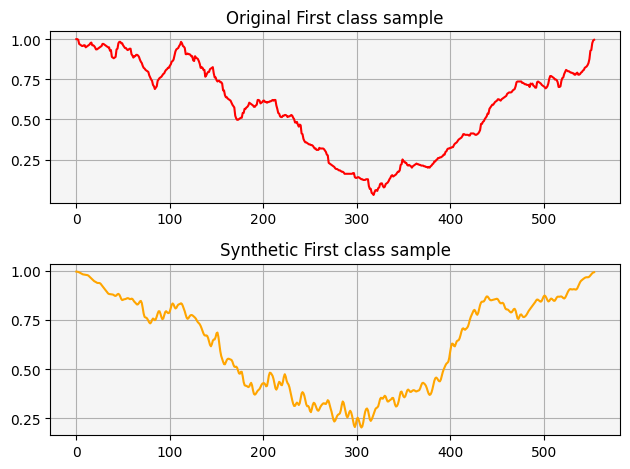

In [ ]:
fig, ax = plt.subplots(2, 1, squeeze=True)

colors = ['red', 'orange']
y = [0.25, 0.5, 0.75, 1]


ax[0].plot(original_first_class[0], color=colors[0])
ax[0].set_title("Original First class sample")
ax[0].grid(True)
ax[0].set_yticks(y)
ax[0].set_fc("whitesmoke")

ax[1].plot(fake_first_class[0], color=colors[1])
ax[1].set_title("Synthetic First class sample")
ax[1].grid(True)
ax[1].set_yticks(y)
ax[1].set_fc("whitesmoke")

plt.tight_layout()
plt.savefig('Results_1.png', dpi=300)
plt.show()

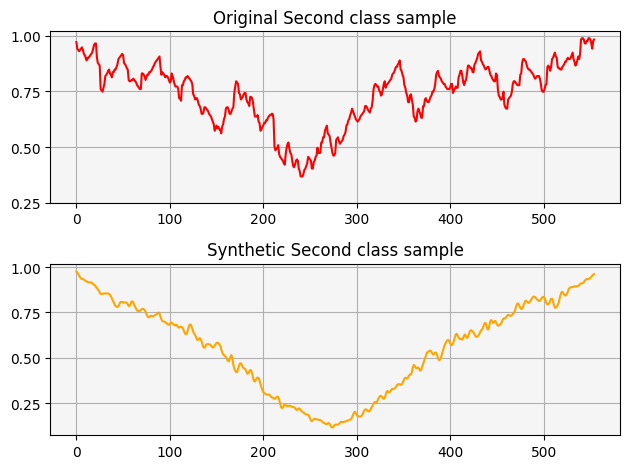

In [ ]:
fig, ax = plt.subplots(2, 1, squeeze=True)

colors = ['red', 'orange']
y = [0.25, 0.5, 0.75, 1]


ax[0].plot(original_third_class[1], color=colors[0])
ax[0].set_title("Original Second class sample")
ax[0].grid(True)
ax[0].set_yticks(y)
ax[0].set_fc("whitesmoke")

ax[1].plot(fake_third_class[1], color=colors[1])
ax[1].set_title("Synthetic Second class sample")
ax[1].grid(True)
ax[1].set_yticks(y)
ax[1].set_fc("whitesmoke")

plt.tight_layout()
plt.savefig('Results_2.png', dpi=300)
plt.show()